In [3]:
%config Completer.use_jedi = False

import sys
sys.path.append("../")
sys.path.append("./DeLinker/analysis/")
sys.path.append("./DeLinker/")

In [69]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Chem import MolStandardize

import numpy as np

from itertools import product
from joblib import Parallel, delayed
import re
from collections import defaultdict

from IPython.display import clear_output
IPythonConsole.ipython_useSVG = True

from DeLinker_test import DenseGGNNChemModel
from analysis import frag_utils, rdkit_conf_parallel
from data.prepare_data import read_file, preprocess
from examples import example_utils

import glob
import pandas as pd

In [58]:
# How many cores for multiprocessing
n_cores = 4
# Whether to use GPU for generating molecules with DeLinker
use_gpu = False

In [20]:
glob.glob('/homes/hadfield/Downloads/*.sdf')

['/homes/hadfield/Downloads/3hb4_B_E2B.sdf',
 '/homes/hadfield/Downloads/6ooy_lig.sdf',
 '/homes/hadfield/Downloads/testnspNoNitr.sdf',
 '/homes/hadfield/Downloads/testnspElab.sdf',
 '/homes/hadfield/Downloads/5o6h_Q_9M2(1).sdf',
 '/homes/hadfield/Downloads/ZINC00537755.sdf',
 '/homes/hadfield/Downloads/5048_lig.sdf',
 '/homes/hadfield/Downloads/testAlign2.sdf',
 '/homes/hadfield/Downloads/5db3_K_58Q.sdf',
 '/homes/hadfield/Downloads/5db2_B_58R.sdf',
 '/homes/hadfield/Downloads/test2.sdf',
 '/homes/hadfield/Downloads/test.sdf',
 '/homes/hadfield/Downloads/testAlign.sdf']

In [26]:
mol = Chem.SDMolSupplier('/homes/hadfield/Downloads/5db3_K_58Q.sdf')[0]

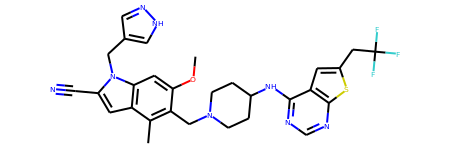

In [27]:
Chem.MolFromSmiles(Chem.MolToSmiles(mol))

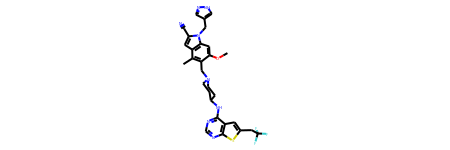

In [28]:
mol

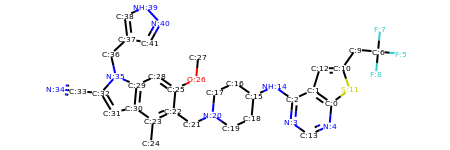

In [29]:
starting_point_2d = Chem.Mol(mol)
_ = AllChem.Compute2DCoords(starting_point_2d)
example_utils.mol_with_atom_index(starting_point_2d)

In [30]:
indices_to_remove = [15,16,17,18,19,20]

In [31]:
indices_to_remove

[15, 16, 17, 18, 19, 20]

In [35]:
coords = np.array([np.array(mol.GetConformer().GetAtomPosition(x)) for x in indices_to_remove])

In [36]:
coords

array([[11.732, 12.216, 11.492],
       [11.564, 13.325, 12.545],
       [10.709, 14.462, 12.089],
       [12.286, 12.87 , 10.247],
       [11.369, 14.046,  9.86 ],
       [11.377, 15.07 , 10.91 ]])

In [47]:
def match_coords_to_indices(mol, coords, linking = True):
  
    remove_indices = []
    for c in coords:

        for atom in mol.GetAtoms():
            if np.linalg.norm(np.array(mol.GetConformer().GetAtomPosition(atom.GetIdx())) - c) < 0.05:
                remove_indices.append(atom.GetIdx())

    print(f'Indices to be removed from Molecule: {remove_indices}')
    elab_ev = []
    frag_ev = []
    for idx in remove_indices:
        for nei in mol.GetAtomWithIdx(idx).GetNeighbors():
            if nei.GetIdx() not in remove_indices:
                elab_ev.append(idx)
                frag_ev.append(nei.GetIdx())

    for idx in range(len(elab_ev)):
        print(f'Exit vector pair {idx + 1}: {frag_ev[idx]}, {elab_ev[idx]}')
                

    bonds_to_break = [mol.GetBondBetweenAtoms(elab_ev[x],frag_ev[x]).GetIdx() for x in range(len(elab_ev))]
    fragmented_mol = Chem.FragmentOnBonds(mol, bonds_to_break)
    fragmentation = Chem.MolToSmiles(fragmented_mol).split('.')
    
    if linking:
        fragments = []
        for fragment in fragmentation:
            if len([x for x in fragment if x =="*"]) ==2:
                linker=fragment
            else:
                fragments.append(fragment)
        fragments = '.'.join(fragments)
        linker = re.sub('[0-9]+\*', '*', linker)
        fragments = re.sub('[0-9]+\*', '*', fragments) 
    
        return linker, fragments, Chem.MolToSmiles(mol)
    
    #len_elab = coords.shape[0]
      

    '''

    if Chem.MolFromSmiles(fragmentation[0]).GetNumHeavyAtoms() == len_elab:
        elaboration = fragmentation[0]
        scaffold = fragmentation[1]
    else:
        elaboration = fragmentation[1]
        scaffold = fragmentation[0]

    elaboration = re.sub('[0-9]+\*', '*', elaboration)
    scaffold = re.sub('[0-9]+\*', '*', scaffold)
    
    return scaffold, elaboration, Chem.MolToSmiles(mol)
    '''

In [51]:
linker, fragments, mol_smiles = match_coords_to_indices(mol, coords)

Indices to be removed from Molecule: [15, 16, 17, 18, 19, 20]
Exit vector pair 1: 14, 15
Exit vector pair 2: 21, 20


In [60]:
len_linker = Chem.MolFromSmiles(linker).GetNumHeavyAtoms()

In [52]:
dist, ang = frag_utils.compute_distance_and_angle(mol, linker, fragments)
fragments, dist, ang


('[*]Nc1ncnc2sc(CC(F)(F)F)cc12.[*]Cc1c(OC)cc2c(cc(C#N)n2Cc2cn[nH]c2)c1C',
 5.618941537336012,
 2.9588270404544383)

In [55]:
data_path = "./fragments_test_data.txt"
with open(data_path, 'w') as f:
    f.write("%s %s %s" % (fragments, dist, ang))

In [56]:
raw_data = read_file(data_path)
preprocess(raw_data, "zinc", "fragments_test", True)

Finished reading: 1 / 1
Parsing smiles as graphs.
Processed: 1 / 1
Saving data
Length raw data: 	1
Length processed data: 	1


In [59]:
import os
if not use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


In [61]:
# Arguments for DeLinker
args = defaultdict(None)
args['--dataset'] = 'zinc'
args['--config'] = '{"generation": true, \
                     "batch_size": 1, \
                     "number_of_generation_per_valid": 50, \
                     "min_atoms": %d, "max_atoms": %d, \
                     "train_file": "molecules_fragments_test.json", \
                     "valid_file": "molecules_fragments_test.json", \
                     "output_name": "DeLinker_example_generation.smi"}' % (len_linker, len_linker)
args['--freeze-graph-model'] = False
args['--restore'] = './DeLinker/models/pretrained_DeLinker_model.pickle'

In [62]:
# Setup model and generate molecules
model = DenseGGNNChemModel(args)
model.train()
# Free up some memory
model = ''

Run 2022-06-04-15-33-24_152263 starting with following parameters:
{"task_sample_ratios": {}, "use_edge_bias": true, "clamp_gradient_norm": 1.0, "out_layer_dropout_keep_prob": 1.0, "tie_fwd_bkwd": true, "random_seed": 0, "batch_size": 1, "prior_learning_rate": 0.05, "stop_criterion": 0.01, "num_epochs": 10, "epoch_to_generate": 10, "number_of_generation_per_valid": 50, "maximum_distance": 50, "use_argmax_generation": false, "residual_connection_on": true, "residual_connections": {"2": [0], "4": [0, 2], "6": [0, 2, 4], "8": [0, 2, 4, 6], "10": [0, 2, 4, 6, 8], "12": [0, 2, 4, 6, 8, 10], "14": [0, 2, 4, 6, 8, 10, 12]}, "num_timesteps": 7, "hidden_size": 32, "encoding_size": 4, "kl_trade_off_lambda": 0.3, "learning_rate": 0.001, "graph_state_dropout_keep_prob": 1, "compensate_num": 0, "train_file": "molecules_fragments_test.json", "valid_file": "molecules_fragments_test.json", "try_different_starting": true, "num_different_starting": 1, "generation": true, "use_graph": true, "label_one_ho

/data/hookbill/hadfield/anaconda3/envs/DeLinker-env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Restoring weights from file ./DeLinker/models/pretrained_DeLinker_model.pickle.
Generated mol 0
Generation done
Number of generated SMILES: 50


In [74]:
def run_DeLinker(sdf_file, coords_to_replace, 
                         data_path_fname = "./DeLinker_test_data",
                         json_out_fname = "DeLinker_test", 
                         num_elabs = 250,
                         output_smi_file = 'gen_linkers', image_fname = 'linked_mols.png'):
    #Load in molecule
    mol = Chem.MolFromMolFile(sdf_file)
  
    #Obtain substructure we're trying to replace via the atomic coordinates
    linker, fragments, mol_smiles = match_coords_to_indices(mol, coords)
    

    
    #Prepare the model to be run
    model_args = process_pharmacophoric_info(mol_smiles, linker, fragments, mol,
                                           data_path_fname=data_path_fname,
                                           json_out_fname=json_out_fname,
                                           num_elabs=num_elabs,
                                           output_smi_file=output_smi_file)
  
    #Make elabs
    generate_linkers(model_args)

    #Summary Statistics
    mol_img = summary_stats(output_smi_file=output_smi_file, image_fname=image_fname)

    return mol_img


def generate_linkers(args):
    model = DenseGGNNChemModel(args)
    model.train()
  
    model = '' #Free up some memory

    return 0


def process_pharmacophoric_info(full_smi, linker_smi, fragments_smi, original_mol,
                                data_path_fname = "./DeLinker_test_data",
                                json_out_fname = "DeLinker_test", 
                                num_elabs = 250,
                                output_smi_file = 'gen_linkers'):

    
    len_linker = Chem.MolFromSmiles(linker_smi).GetNumHeavyAtoms()
    dist, ang = frag_utils.compute_distance_and_angle(original_mol, linker_smi, fragments_smi)
    
        
    with open(data_path_fname, 'w') as f:
        f.write("%s %s %s" % (fragments, dist, ang))
        
    raw_data = read_file(data_path_fname)
    preprocess(raw_data, "zinc", json_out_fname, True)    
    
    # Arguments for DeLinker
    args = defaultdict(None)
    args['--dataset'] = 'zinc'
    args['--config'] = '{"generation": true, \
                         "batch_size": 1, \
                         "number_of_generation_per_valid": %d, \
                         "min_atoms": %d, "max_atoms": %d, \
                         "train_file": "molecules_%s.json", \
                         "valid_file": "molecules_%s.json", \
                         "output_name": "DeLinker_%s.smi"}' % (num_elabs, len_linker, len_linker, 
                                                              json_out_fname, json_out_fname, 
                                                              output_smi_file)
    args['--freeze-graph-model'] = False
    args['--restore'] = './DeLinker/models/pretrained_DeLinker_model.pickle'
    

    return args


def summary_stats(output_smi_file, image_fname = None):

    DeLinker_mols = pd.read_csv(f"DeLinker_{output_smi_file}.smi", sep = ' ')
    DeLinker_mols.columns = ['frag', 'full', 'gen']

    gen_vc = DeLinker_mols['gen'].value_counts()
    img = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in list(gen_vc.index)[:12]], molsPerRow = 3)

    img.save(image_fname)
    return img

In [72]:
img = run_DeLinker('/homes/hadfield/Downloads/5db3_K_58Q.sdf', coords)

Indices to be removed from Molecule: [15, 16, 17, 18, 19, 20]
Exit vector pair 1: 14, 15
Exit vector pair 2: 21, 20
Finished reading: 1 / 1
Parsing smiles as graphs.
Processed: 1 / 1
Saving data
Length raw data: 	1
Length processed data: 	1
Run 2022-06-04-17-36-13_152263 starting with following parameters:
{"task_sample_ratios": {}, "use_edge_bias": true, "clamp_gradient_norm": 1.0, "out_layer_dropout_keep_prob": 1.0, "tie_fwd_bkwd": true, "random_seed": 0, "batch_size": 1, "prior_learning_rate": 0.05, "stop_criterion": 0.01, "num_epochs": 10, "epoch_to_generate": 10, "number_of_generation_per_valid": 250, "maximum_distance": 50, "use_argmax_generation": false, "residual_connection_on": true, "residual_connections": {"2": [0], "4": [0, 2], "6": [0, 2, 4], "8": [0, 2, 4, 6], "10": [0, 2, 4, 6, 8], "12": [0, 2, 4, 6, 8, 10], "14": [0, 2, 4, 6, 8, 10, 12]}, "num_timesteps": 7, "hidden_size": 32, "encoding_size": 4, "kl_trade_off_lambda": 0.3, "learning_rate": 0.001, "graph_state_dropout_k

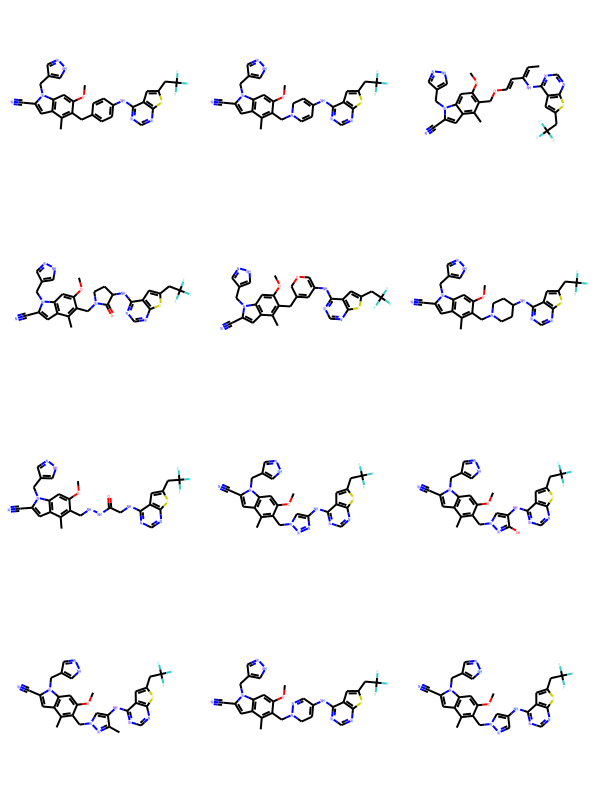

In [73]:
img